In [6]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from helpers import read_manual_results, predict_on_cv2_frames

In [7]:
import torch
from architectures import CircleRegressor
import torchvision.transforms as T
from PIL import Image

from typing import Tuple

mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)

val_tf = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

model_path = f"./models/circle_regressor_v1.pt"

device = 'cpu'

model = CircleRegressor(pretrained=True)
state = torch.load(model_path, map_location=device)
model.load_state_dict(state)
model.eval();

Processing frames: 100%|██████████| 638/638 [00:51<00:00, 12.39it/s]


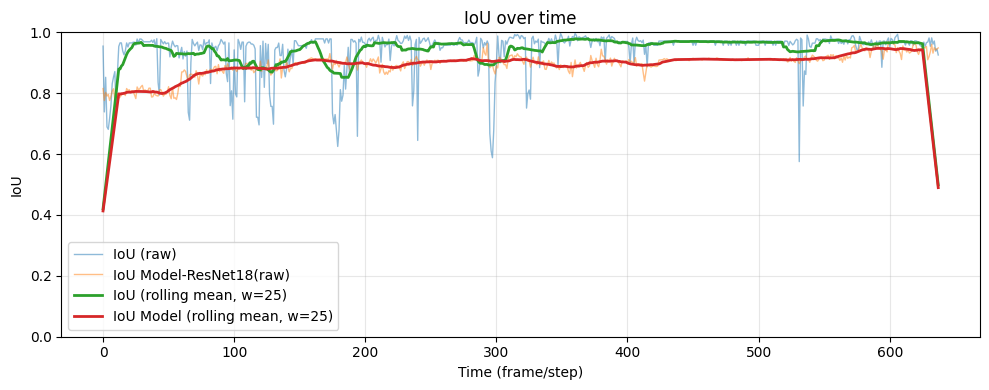

In [ ]:
from metrics import circle_iou
from red_circle_detection import detect_red_circle
from tqdm import tqdm
from helpers import get_gt_circles

session = 2
participant = 22

par = f"./data/processed_data/Session{session}_Light/Participant{participant}"

manual_path = os.path.join(par, "normalized_results_manual.txt")
frames_path = os.path.join(par, "video_frames")

df = read_manual_results(manual_path)

ious = []
model_ious = []

w = 640
h = 360

for i in tqdm(range(len(df)), total=len(df), desc="Processing frames"):

    curr = df.iloc[i]

    time, r_gt, g_gt = get_gt_circles(curr)

    image_path = os.path.join(frames_path, f"img{time}.jpg")
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)

    r_model, g_model = predict_on_cv2_frames(model, img, transform=val_tf, device='cpu')
    _, x2, y2, r2 = detect_red_circle(img)

    x2 /= w
    y2 /= h
    r2 /= min(w, h)
    
    r_class = (x2, y2, r2)

    iou = circle_iou(r_gt, r_class)
    model_iou = circle_iou(r_gt, r_model)

    ious.append(iou)
    model_ious.append(model_iou)


ious = np.array(ious, dtype=float)
model_ious = np.array(model_ious, dtype=float)

x = np.arange(len(ious))

window = 25
kernel = np.ones(window) / window

smooth = np.convolve(ious, kernel, mode="same")
model_smooth = np.convolve(model_ious, kernel, mode="same")

alpha = 0.5

plt.figure(figsize=(10, 4))
plt.plot(x, ious, alpha=alpha, linewidth=1, label="IoU (raw)")
plt.plot(x, model_ious, alpha=alpha, linewidth=1, label="IoU Model-ResNet18(raw)")

plt.plot(x, smooth, linewidth=2, label=f"IoU (rolling mean, w={window})")
plt.plot(x, model_smooth, linewidth=2, label=f"IoU Model (rolling mean, w={window})")

plt.ylim(0, 1)
plt.xlabel("Time (frame/step)")
plt.ylabel("IoU")
plt.title("IoU over time")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
